In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as sco
plt.style.use('fivethirtyeight')
np.random.seed(777)
xrange=range
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
table = pd.read_excel('MASTER FILE.xlsx')

table = table.round(2)

table.set_index("Date", inplace = True)
display(table.head())

,AUROPHARMA,GLAXO,GLENMARK,ZYDUSLIFE,WIPRO,TECHM,BSOFT,HCLTECH,SUPRAJIT,BOSCHLTD,JAMNAAUTO,MAHSCOOTER,TCI,SCI,AEGISCHEM,GPPL,NCC,KNRCON,LT,KALPATPOWR
Date,,,,,,,,,,,,,,,,,,,,
2012-10-01,72.18,1001.58,417.70,170.06,143.51,256.39,68.87,145.29,28.35,8838.30,11.80,360.00,42.74,59.3,15.94,51.90,48.55,11.36,714.09,85.30
2012-10-03,73.22,990.15,419.45,171.80,142.59,248.55,68.90,147.84,28.60,8810.80,11.86,356.65,45.25,59.7,15.46,51.85,49.60,11.58,715.14,87.20
2012-10-04,72.35,976.05,407.00,166.07,143.59,242.95,67.63,147.26,28.00,8909.00,11.80,368.25,44.37,59.2,16.24,53.00,51.70,11.79,726.25,88.90
2012-10-05,69.30,971.52,399.95,163.88,139.97,236.70,65.82,143.39,27.55,8734.75,11.72,361.00,44.03,57.8,17.24,52.00,51.75,11.64,733.29,88.60
2012-10-08,71.72,968.32,407.00,168.00,137.02,235.01,66.86,139.69,27.10,8625.05,11.50,361.00,43.59,57.3,18.18,51.55,53.00,11.48,709.23,89.65


Text(0, 0.5, 'price in ₹')

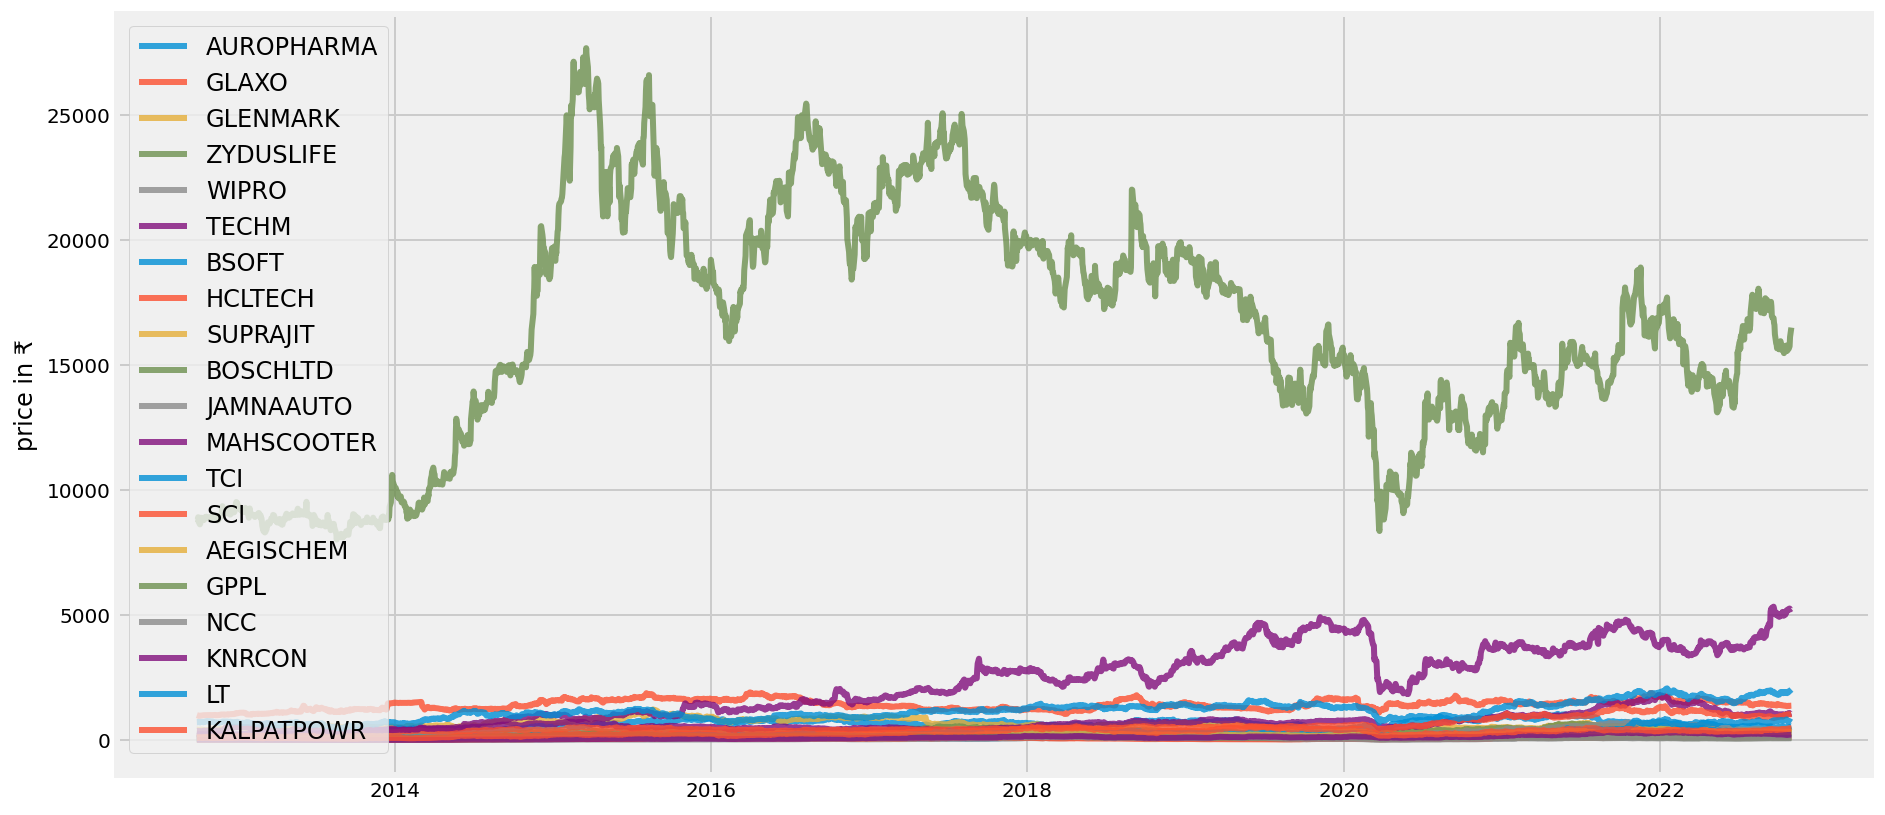

In [5]:
plt.figure(figsize=(14, 7))
for c in table.columns.values:
    plt.plot(table.index, table[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('price in ₹')

Text(0, 0.5, 'Daily Returns (%)')

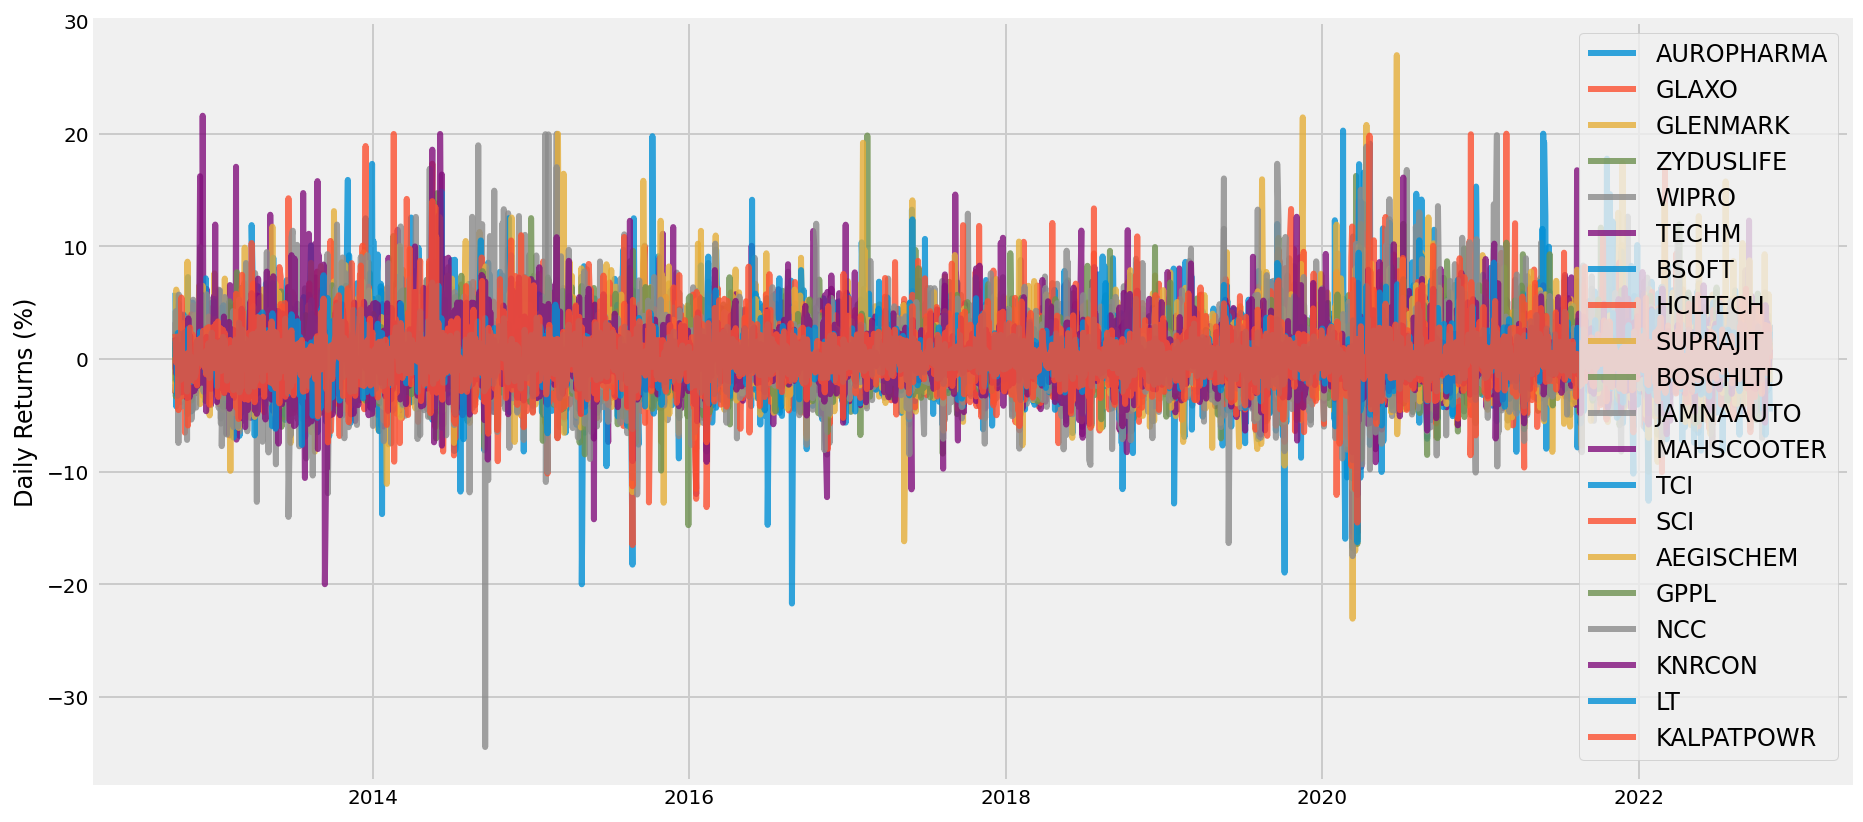

In [6]:
returns = table.pct_change()
plt.figure(figsize=(14, 7))
for c in returns.columns.values:
    plt.plot(returns.index, returns[c]*100, lw=3, alpha=0.8,label=c)
plt.legend(loc='upper right', fontsize=12)
plt.ylabel('Daily Returns (%)')
# returns.to_excel('returns.xlsx')

In [4]:
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns * weights) *252
    
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns
  
def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3,num_portfolios))
    weights_record = []
    for i in xrange(num_portfolios):
        xs = np.random.randint(-100,100,20)
        xs[xs==0] = np.random.randint(1,100)
        if sum(xs)!=0:
            s = sum(xs)
            xs = [ i/s for i in xs ]
            xs1 = [x for x in xs]
#             print(xs)
#             print(len(xs))
#             print(sum(xs))
        else:
            continue
            
        weights = np.array(xs1)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_record

In [5]:
returns = table.pct_change()
mean_returns = returns.mean()
cov_matrix = returns.cov()

num_portfolios = 50000

# 10 yr GS as on 22 Nov 2022
risk_free_rate = 0.073201

In [17]:
def display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, weights = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index=table.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    
    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index=table.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print("-"*80)
    print("Maximum Sharpe Ratio Portfolio Allocation\n")
    print("Annualised Return: %", round(rp*100,2))
    print("Annualised Volatility: %", round(sdp*100,2))
    print("\n")
    print(max_sharpe_allocation)
#     print("-"*80)
#     print("Minimum Volatility Portfolio Allocation\n")
#     print("Annualised Return: %", round(rp_min,2)*100)
#     print("Annualised Volatility: %", round(sdp_min,2)*100)
#     print("\n")
#     print(min_vol_allocation)
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=5, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
#     plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')
    plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('Annualised Volatility')
    plt.ylabel('Annualised Returns')
    plt.legend(labelspacing=0.8)
    plt.savefig('foo2.png', bbox_inches='tight')

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: % 44.2
Annualised Volatility: % 28.62


            AUROPHARMA  GLAXO  GLENMARK  ZYDUSLIFE  WIPRO  TECHM  BSOFT  \
allocation       -1.53 -16.48    -18.77      26.05   2.68  -0.38  20.31   

            HCLTECH  SUPRAJIT  BOSCHLTD  JAMNAAUTO  MAHSCOOTER    TCI    SCI  \
allocation    22.61     36.78     -24.9     -11.88        7.28  31.42 -12.26   

            AEGISCHEM  GPPL    NCC  KNRCON    LT  KALPATPOWR  
allocation      25.67 -5.36  15.71   11.11 -9.96        1.92  


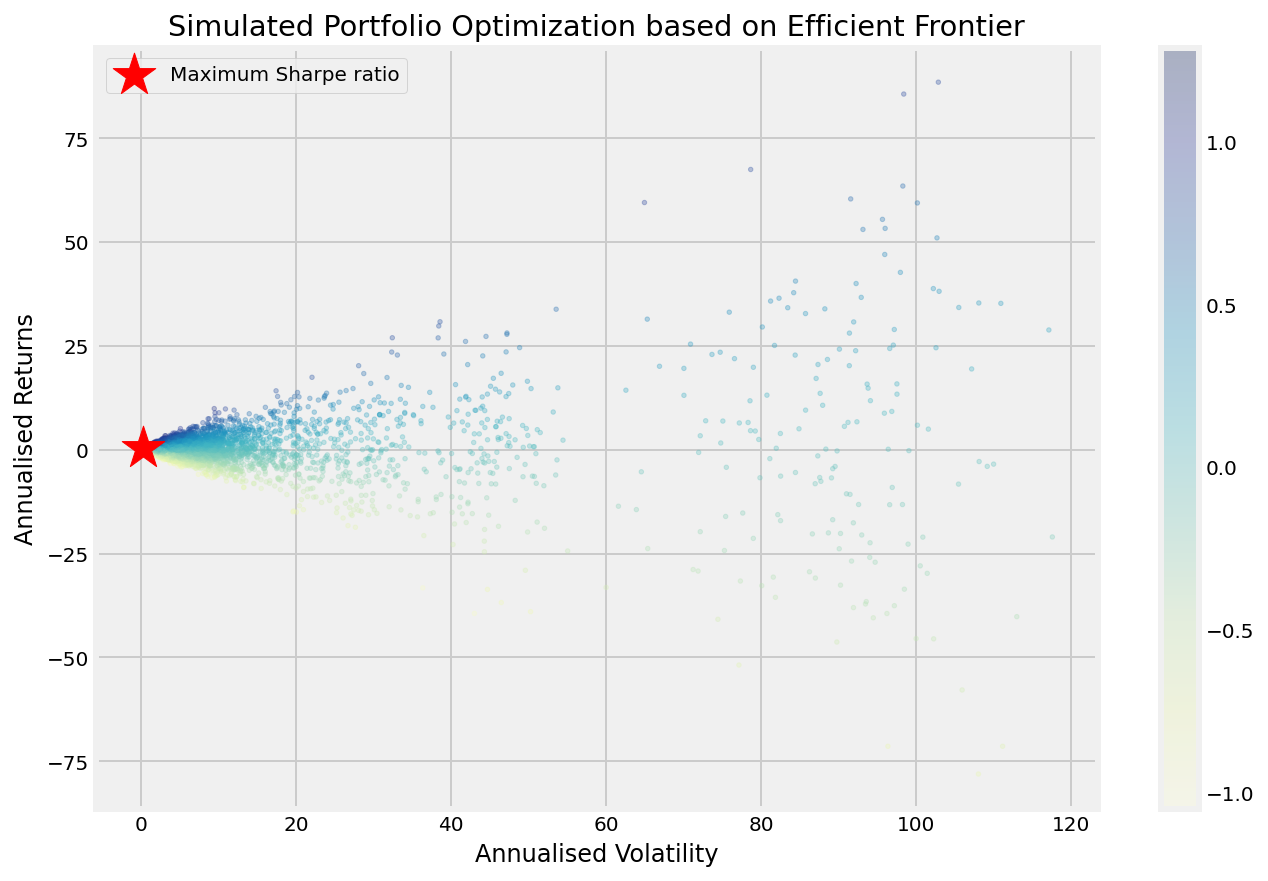

In [22]:
display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)